In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp


In [2]:
# T_theta = 125 # ms, theta osicillation period
A_STDP = 0.03; s_STDP = 4 # parameters for STDP
omega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * np.sin(dx) # gabor as STDP rule
domega = lambda dx: A_STDP * np.exp(s_STDP*np.cos(dx)) * (np.cos(dx) - s_STDP*np.sin(dx)**2) # derivative of STDP in respect to xi (postsynaptic)
# plot STDP and PCF
# u = np.arange(-np.pi,np.pi,np.pi/120)
# plt.plot(u,omega(u))
# plt.plot(u,domega(u))
# plt.plot(u,domega(u)*omega(u))

In [3]:
def mainode(t,x):
    # global variables:
    # N is number of neurons
    # Wij is the synpatic efficancy from neuron j to i
    # sigma2_w is the variance of W
    # x_tilde is the recall cue
    # k_{prior,noise} is the concentration of prior and 
    # cue distribution
    # x_fire is list of each neuron's list of firing 
    # phase, dynamically updated at each event
    H = np.zeros((N,N))
    for j in range(N):
        if x_fire[j]: # if neuron j has fired
            xj = x_fire[j][-1] # we need the last firing phase
            dxij = x-xj # phase difference between neurons
            H[:,j] = W[:,j] * domega(dxij) # phase interaction
                                           # from neuron j
                                           # to neuron i
                                           # Hjj is guarenteed
                                           # to be 0 because
                                           # Wjj is 0
    dx_prior    = -k_prior * np.sin(x) 
    dx_external = -k_noise * np.sin(x-x_tilde)
    dx_synapse  = np.sum(H,1)/sigma2_w # sum_j H_{ij}/sigma_w^2
    return dx_prior + dx_external + dx_synapse

In [4]:
N = 200	# number of neurons
event = [lambda t,x:            # event[i](t,x)
        np.sin((x[j]-t)/2)      # equals 0 when firing phase
        for j in range(N)]      # of neuron i matches current LFP 
                                # i.e. (x[i]-t) mod 2pi ==0 
for func in event: 
        func.terminal = True


In [5]:
N = N	# number of neurons
M = 15	# number of memories
k_prior = 0.5	# von Mises concentration parameter
                # for prior distribution
k_noise = 10	# for cue distribution
x_memory = np.random.vonmises(0,k_prior,(N,M)) # every column 
                                        # is a memory trace
x_0 = np.random.vonmises(0,k_prior,N)
x_target = x_memory[:,0].copy()            # the first one is 
                                    # what we want to recall
x_noise = np.random.vonmises(0,k_noise,N)   # indepedent random
                                # noise to corrupt the cue
x_tilde = x_target + x_noise
W = np.zeros((N,N))
for i in range(N):
    for j in range(i): # j<i, Wii = 0
        for k in range(M): # the STDP rule is additive
            W[i,j] += omega(x_memory[i,k]-x_memory[j,k])
            W[j,i] += omega(x_memory[j,k]-x_memory[i,k])
W_flatten = [W[i][j] for i in range(N) for j in range(i) ]
sigma2_w = np.var(W_flatten)
# plt.hist(W_flatten,50)

x_fire = [[ ] for j in range(N)] # record firing phase


In [6]:
print(not np.any(np.diag(W)))
i,j = np.random.randint(0,N,2)
print(W[i,j] + W[j,i] == 0)

True
True


In [7]:
p=np.argmin(np.mod(x_tilde,2*np.pi))
print(x_target[p])
print(x_tilde[p])

0.3089137920113165
0.007976000276099349


In [8]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        x_fire += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
print(len(xNow))

A termination event occurred.
0.04638772204924749
200


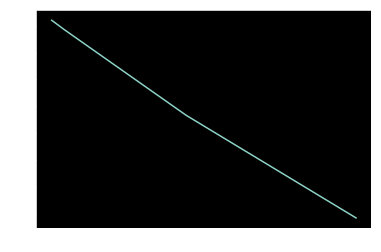

In [9]:
plt.plot(t,x[p,:])

In [10]:
while tNow <= tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)
        x = np.append(x,sol.y,axis=1)
        tNow = t[-1]
        xNow = x[-1]
        for j,te in enumerate(sol.t_events):
                x_fire += list(te)  # update x_fire for calculating H
        print(sol.message)
        print(tNow)
        





A termination event occurred.
0.04638772204924749


ValueError: operands could not be broadcast together with shapes (6,) (200,) 

In [11]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te:
                x_fire[j] += list(te)      # update x_fire for calculating H

print(sol.message)
print(tNow)
print(len(xNow))

A termination event occurred.
0.04638772204924749
200


C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


In [12]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                x_fire[j] += list(te)      # update x_fire for calculating H

print(sol.message)
print(tNow)
print(len(xNow))

A termination event occurred.
0.047130504421116284
200


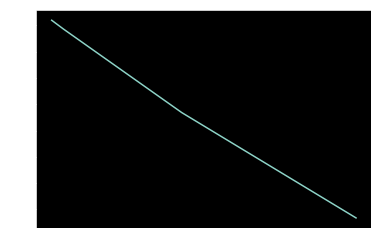

In [13]:
plt.plot(t,x[p,:])

In [14]:
while tNow <= tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)
        x = np.append(x,sol.y,axis=1)
        tNow = t[-1]
        xNow = x[-1]
        for j,te in enumerate(sol.t_events):
                x_fire[j] += list(te)  # update x_fire for calculating H
        print(sol.message)
        print(tNow)
        





A termination event occurred.
0.047130504421116284


ValueError: operands could not be broadcast together with shapes (200,) (6,) 

In [15]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
print(len(xNow))

A termination event occurred.
0.047131786008526126
200


In [16]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
len(sol.event)
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

AttributeError: event

In [17]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
print(len(xNow))

0
127
A termination event occurred.
0.0471317882160801
200


In [18]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
len(sol.t_events)
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

A termination event occurred.
5.6407103177258
0
127
128


[array([5.64071032]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=

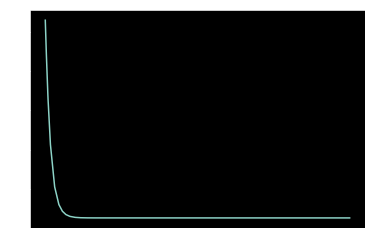

In [19]:
plt.plot(t,x[p,:])
print(sol.t_events)

In [20]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
127
128
A termination event occurred.
0.04067961790833664


[array([0.04067962]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=

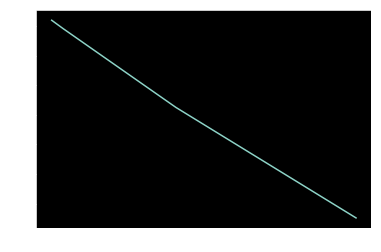

In [21]:
plt.plot(t,x[p,:])
print(sol.t_events)

In [22]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
127
128
129
A termination event occurred.
0.04631452675534003


In [23]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
A termination event occurred.
0.04631452675534003
0
127
128
129
130


In [24]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
127
128
129
130
A termination event occurred.
0.04886795322747428


In [25]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
127
128
129
130
131
A termination event occurred.
0.05444088306413129


In [26]:
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t.copy(); tNow = t[-1]         # record time
x = sol.y.copy(); xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
127
128
129
130
131
132
A termination event occurred.
0.06141801612670147


In [27]:
for func in event: 
        func.terminal = True

tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t.copy(); tNow = t[-1]         # record time
x = sol.y.copy(); xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
A termination event occurred.
0.07640276920938102


In [28]:
for func in event: 
        func.terminal = True

tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t.copy(); tNow = t[-1]         # record time
x = sol.y.copy(); xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
A termination event occurred.
0.07645557647238722


In [29]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
A termination event occurred.
5.412695910944079
0
127


In [30]:
for func in event: 
        func.terminal = True

tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t.copy(); tNow = t[-1]         # record time
x = sol.y.copy(); xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
A termination event occurred.
0.07645575250815098


[array([0.07645575]), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=float64), array([], dtype=

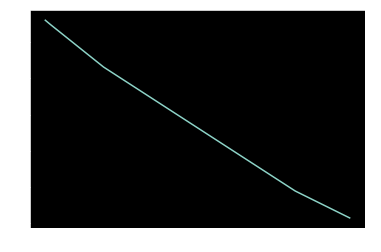

In [31]:
plt.plot(t,x[p,:])
print(sol.t_events)

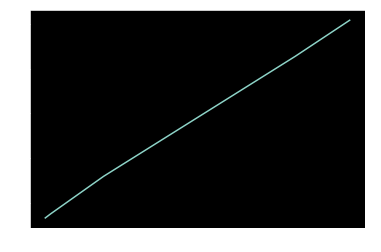

In [32]:
plt.plot(t,x[0,:])
# print(sol.t_events)

In [33]:
while tNow <= tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)
        x = np.append(x,sol.y,axis=1)
        tNow = t[-1]
        xNow = x[:,-1]
        for j,te in enumerate(sol.t_events):
                event[j].terminal = True
                if te.size>0:
                        x_fire[j] += list(te)  # update x_fire for calculating H
                        event[j].terminal = False
        print(sol.message)
        print(tNow)
        





A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.07645575250815098
A termination event occurred.
0.2266119589442629
A termination event occurred.
0.2266119589442629
A termination event occurred.
6.581523882673386
A termination event occurred.
6.6735172942951
A termination event occurred.
6.6735172942951
A terminatio

A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event occurred.
11.866897751424236
A termination event 

The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached 

The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached 

The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached 

The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached the end of the integration interval.
12.566370614359172
The solver successfully reached 

KeyboardInterrupt: 

In [34]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
The solver successfully reached the end of the integration interval.
12.566370614359172


In [35]:
for func in event: 
        func.terminal = True

tf = 2*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t.copy(); tNow = t[-1]         # record time
x = sol.y.copy(); xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))


0
A termination event occurred.
0.046992188551044076


In [36]:
while tNow < tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)
        x = np.append(x,sol.y,axis=1)
        tNow = t[-1]
        xNow = x[:,-1]
        for j,te in enumerate(sol.t_events):
                event[j].terminal = True
                if te.size>0:
                        x_fire[j] += list(te)  # update x_fire for calculating H
                        event[j].terminal = False
        print(sol.message)
        print(tNow)
        





A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0.046992188551044076
A termination event occurred.
0

KeyboardInterrupt: 

In [37]:
for func in event: 
        func.terminal = True

tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t.copy(); tNow = t[-1]         # record time
x = sol.y.copy(); xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
A termination event occurred.
0.041329166569770356


In [38]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
A termination event occurred.
6.25265695689237
0
127


[6.25265695689237]


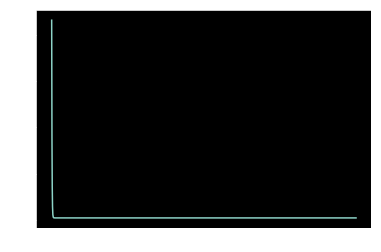

In [39]:
p=0
plt.plot(t,x[p,:])
print(list(sol.t_events[p]))

# print(sol.t_events)

In [40]:
for func in event: 
        func.terminal = True

tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
A termination event occurred.
0.04132426148311323


In [41]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
A termination event occurred.
6.252656974543995
0
127


[6.252656974543995]


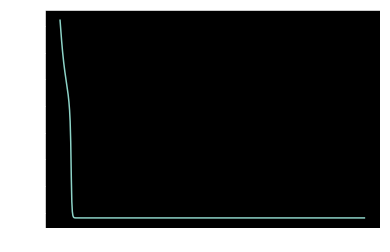

In [42]:
p=127
plt.plot(t,x[p,:])
print(list(sol.t_events[p]))

# print(sol.t_events)

In [43]:
print(t)
# print(sol.t_events)

[0.00000000e+00 6.30204697e-04 6.19117419e-03 1.18238583e-02
 1.75064848e-02 2.43867664e-02 3.26953300e-02 4.10038936e-02
 4.13242615e-02 4.13242615e-02 5.23576208e-02 6.33909800e-02
 7.59755877e-02 8.72064575e-02 9.84373272e-02 1.09668197e-01
 1.24447055e-01 1.37067485e-01 1.49687915e-01 1.66205421e-01
 1.82840453e-01 1.95907268e-01 2.07507562e-01 2.19413706e-01
 2.31319850e-01 2.41899285e-01 2.52680831e-01 2.64581486e-01
 2.77180047e-01 2.87734247e-01 2.98418718e-01 3.10282647e-01
 3.22928115e-01 3.33510596e-01 3.44231776e-01 3.56090495e-01
 3.68714669e-01 3.79286656e-01 3.89995360e-01 4.01856018e-01
 4.14498769e-01 4.25070802e-01 4.35772336e-01 4.47628081e-01
 4.60275791e-01 4.70850048e-01 4.81553993e-01 4.93406143e-01
 5.06046205e-01 5.16621864e-01 5.27331694e-01 5.39189358e-01
 5.51829378e-01 5.62402835e-01 5.73108965e-01 5.84966845e-01
 5.97610428e-01 6.08183574e-01 6.18887062e-01 6.30743039e-01
 6.43388355e-01 6.53962393e-01 6.64666889e-01 6.76522565e-01
 6.89166244e-01 6.997403

In [44]:
print(t[-5:])
print(x[])
# print(sol.t_events)

SyntaxError: invalid syntax (<ipython-input-47-8b65865efaec>, line 3)

[6.21572259 6.22836621 6.23894009 6.24964495 6.25265697]
[[ 0.06358486  0.09483217  0.28668381 ...  0.4134614   0.4134614
   0.4134614 ]
 [-0.52472668 -0.49503181 -0.05898816 ...  0.41039211  0.41039211
   0.41039211]
 [ 1.65521339  1.65930877  1.69629055 ...  4.01805406  4.01805406
   4.01805406]
 [-0.75204392 -0.74473647 -0.69936832 ... -0.6563855  -0.6563855
  -0.6563855 ]
 [ 0.42915844  0.41943141  0.33675189 ... -0.03052833 -0.03052833
  -0.03052833]]


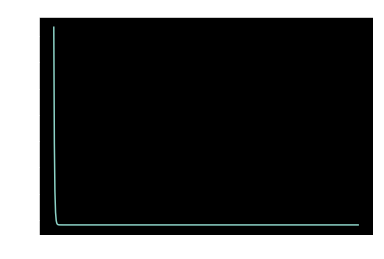

In [45]:
print(t[-5:])
print(x[-5:])
plt.plot(t[t>0.5],x[p,t>0.5])
# print(sol.t_events)

In [46]:
print(tNow%(2*np.pi))
# print(sol.t_events)

6.252656974543995


[6.21572259 6.22836621 6.23894009 6.24964495 6.25265697]
[[ 0.06358486  0.09483217  0.28668381 ...  0.4134614   0.4134614
   0.4134614 ]
 [-0.52472668 -0.49503181 -0.05898816 ...  0.41039211  0.41039211
   0.41039211]
 [ 1.65521339  1.65930877  1.69629055 ...  4.01805406  4.01805406
   4.01805406]
 [-0.75204392 -0.74473647 -0.69936832 ... -0.6563855  -0.6563855
  -0.6563855 ]
 [ 0.42915844  0.41943141  0.33675189 ... -0.03052833 -0.03052833
  -0.03052833]]


C:\Users\golde\Anaconda3\lib\site-packages\matplotlib\ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


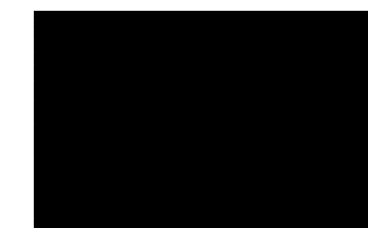

In [47]:
print(t[-5:])
print(x[-5:])
plt.semilogy(t[t>0.5],x[p,t>0.5]-tNow+2*np.pi)

# print(sol.t_events)

In [48]:
print(t[-5:])
print(x[-5:]-tNow+2*np.pi)
# plt.semilogy(t[t>0.5],x[p,t>0.5]-tNow+2*np.pi)

# print(sol.t_events)

[6.21572259 6.22836621 6.23894009 6.24964495 6.25265697]
[[ 9.41131931e-02  1.25360498e-01  3.17212142e-01 ...  4.43989737e-01
   4.43989737e-01  4.43989737e-01]
 [-4.94198347e-01 -4.64503479e-01 -2.84598274e-02 ...  4.40920445e-01
   4.40920445e-01  4.40920445e-01]
 [ 1.68574172e+00  1.68983711e+00  1.72681888e+00 ...  4.04858239e+00
   4.04858239e+00  4.04858239e+00]
 [-7.21515589e-01 -7.14208133e-01 -6.68839985e-01 ... -6.25857165e-01
  -6.25857165e-01 -6.25857165e-01]
 [ 4.59686769e-01  4.49959740e-01  3.67280221e-01 ... -1.77635684e-15
  -1.77635684e-15 -1.77635684e-15]]


[6.21572259 6.22836621 6.23894009 6.24964495 6.25265697]
[[ 9.41131931e-02  1.25360498e-01  3.17212142e-01 ...  4.43989737e-01
   4.43989737e-01  4.43989737e-01]
 [-4.94198347e-01 -4.64503479e-01 -2.84598274e-02 ...  4.40920445e-01
   4.40920445e-01  4.40920445e-01]
 [ 1.68574172e+00  1.68983711e+00  1.72681888e+00 ...  4.04858239e+00
   4.04858239e+00  4.04858239e+00]
 [-7.21515589e-01 -7.14208133e-01 -6.68839985e-01 ... -6.25857165e-01
  -6.25857165e-01 -6.25857165e-01]
 [ 4.59686769e-01  4.49959740e-01  3.67280221e-01 ... -1.77635684e-15
  -1.77635684e-15 -1.77635684e-15]]


C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


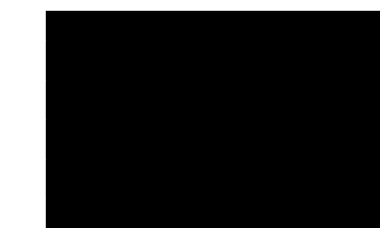

In [49]:
print(t[-5:])
print(x[-5:]-tNow+2*np.pi)
plt.plot(t[t>0.5],np.log(x[p,t>0.5]-tNow+2*np.pi))

[6.21572259 6.22836621 6.23894009 6.24964495 6.25265697]
[[ 9.41131931e-02  1.25360498e-01  3.17212142e-01 ...  4.43989737e-01
   4.43989737e-01  4.43989737e-01]
 [-4.94198347e-01 -4.64503479e-01 -2.84598274e-02 ...  4.40920445e-01
   4.40920445e-01  4.40920445e-01]
 [ 1.68574172e+00  1.68983711e+00  1.72681888e+00 ...  4.04858239e+00
   4.04858239e+00  4.04858239e+00]
 [-7.21515589e-01 -7.14208133e-01 -6.68839985e-01 ... -6.25857165e-01
  -6.25857165e-01 -6.25857165e-01]
 [ 4.59686769e-01  4.49959740e-01  3.67280221e-01 ... -1.77635684e-15
  -1.77635684e-15 -1.77635684e-15]]


C:\Users\golde\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


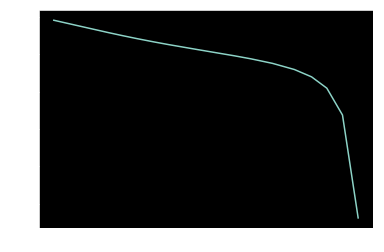

In [50]:
print(t[-5:])
print(x[-5:]-tNow+2*np.pi)
plt.plot(t[:-1],np.log(x[p,:-1]-tNow+2*np.pi))

[6.252656974543995]


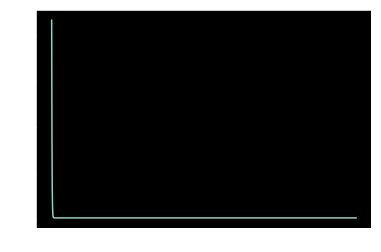

In [51]:
p=0
plt.plot(t,x[p,:])
print(list(sol.t_events[p]))

[6.21572259 6.22836621 6.23894009 6.24964495 6.25265697]
[[ 9.41131931e-02  1.25360498e-01  3.17212142e-01 ...  4.43989737e-01
   4.43989737e-01  4.43989737e-01]
 [-4.94198347e-01 -4.64503479e-01 -2.84598274e-02 ...  4.40920445e-01
   4.40920445e-01  4.40920445e-01]
 [ 1.68574172e+00  1.68983711e+00  1.72681888e+00 ...  4.04858239e+00
   4.04858239e+00  4.04858239e+00]
 [-7.21515589e-01 -7.14208133e-01 -6.68839985e-01 ... -6.25857165e-01
  -6.25857165e-01 -6.25857165e-01]
 [ 4.59686769e-01  4.49959740e-01  3.67280221e-01 ... -1.77635684e-15
  -1.77635684e-15 -1.77635684e-15]]


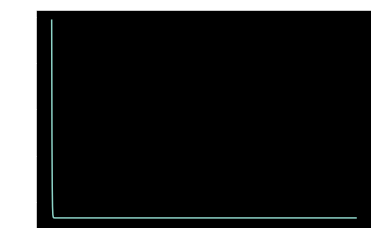

In [52]:
print(t[-5:])
print(x[-5:]-tNow+2*np.pi)
plt.plot(t[:-1],(x[p,:-1]-tNow+2*np.pi))

In [53]:
for func in event: 
        func.terminal = True

tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

0
A termination event occurred.
0.04132425711623757


In [54]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
A termination event occurred.
6.2526569745597085
0
127


[6.2526569745597085]


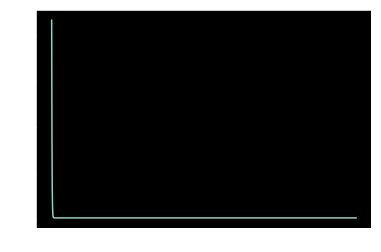

In [55]:
p=0
plt.plot(t,x[p,:])
print(list(sol.t_events[p]))

[6.2526569745597085]


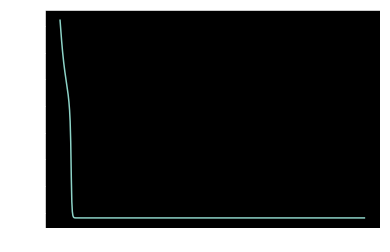

In [56]:
p=127
plt.plot(t,x[p,:])
print(list(sol.t_events[p]))

In [57]:
p=127
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
event[p](tFire,x[p,t==tFire])

[6.2526569745597085]


IndexError: index 199 is out of bounds for axis 0 with size 1

In [58]:
p=127
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
event[p](tFire,x[:,t==tFire])

[6.2526569745597085]


array([7.6571374e-16])

In [59]:
p=0
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
event[p](tFire,x[:,t==tFire])

[6.2526569745597085]


array([7.6571374e-16])

In [60]:
p=0
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
event[p](tFire,x[:,t==tFire])
print(x[p,t==tFire])

[6.2526569745597085]
[0.35222468]


In [61]:
p=127
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
event[p](tFire,x[:,t==tFire])
print(x[p,t==tFire])

[6.2526569745597085]
[-0.29714625]


In [62]:
p=1
event[p](tFire,x[:,t==tFire])
print(x[p,t==tFire])

[5.4983618]


In [63]:
p=127
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire]))
print(x[p,t==tFire])

[6.2526569745597085]
[7.6571374e-16]
[-0.29714625]


In [64]:
p = 1
event[p](0,np.linspace(0,np.pi,N))




1.0

In [65]:
p = 0
print(event[p](0,np.linspace(0,np.pi,N)))




1.0


In [66]:
p = 10
print(event[p](0,np.linspace(0,np.pi,N)))




1.0


In [67]:
N = 200	# number of neurons
event = [None] * N
for j in range(N):
        event[j] = lambda t,x:  # event[i](t,x)
        np.sin((x[j]-t)/2)      # equals 0 when firing phase
                                # of neuron i matches current LFP 
                                # i.e. (x[i]-t) mod 2pi ==0 


SyntaxError: invalid syntax (<ipython-input-70-9812ff43810a>, line 5)

In [68]:
N = 200	# number of neurons
event = [None] * N
for j in range(N):
        event[j] = lambda t,x: np.sin((x[j]-t)/2)      
                # event[i](t,x)
                # equals 0 when firing phase
                # of neuron i matches current LFP
                # i.e. (x[i]-t) mod 2pi ==0                                  
                                


In [69]:
p = 10
print(event[p](0,np.linspace(0,np.pi,N)))




1.0


In [70]:
p = 10
func = event[p]
print(func(0,np.linspace(0,np.pi,N)))

1.0


In [71]:
p = 0
func = event[p]
print(func(0,np.linspace(0,np.pi,N)))

1.0


In [72]:
N = 200	# number of neurons
event = [None] * N
for j in range(N):
        event[j] = lambda t,x: np.sin((x[j]-t)/2)      
                # event[i](t,x)
                # equals 0 when firing phase
                # of neuron i matches current LFP
                # i.e. (x[i]-t) mod 2pi ==0                                  
                                


In [73]:
print(event[0])                               


<function <lambda> at 0x0000023452D73730>


In [74]:
print(event[1])                               


<function <lambda> at 0x0000023452D73E18>


In [75]:
print(event[2])                               


<function <lambda> at 0x00000234509E1048>


In [76]:
p = 0
func = event[p]
xx
print(xx[:10])
print(func(0,xx))

NameError: name 'xx' is not defined

In [77]:
p = 0
func = event[p]
xx=np.linspace(0,np.pi,N)k
print(xx[:10])
print(func(0,xx))

SyntaxError: invalid syntax (<ipython-input-80-780a11763d05>, line 4)

In [78]:
p = 0
func = event[p]
xx=np.linspace(0,np.pi,N)
print(xx[:10])
print(func(0,xx))

[0.         0.0157869  0.0315738  0.04736069 0.06314759 0.07893449
 0.09472139 0.11050828 0.12629518 0.14208208]
1.0


In [79]:
N = 200	# number of neurons
event = [lambda t,x: np.sin((x[j]-t)/2) for j in range(N)]      
        # event[i](t,x)
        # equals 0 when firing phase
        # of neuron i matches current LFP 
        # i.e. (x[i]-t) mod 2pi ==0                                 

In [80]:
p = 0
print(event[p](0,np.linspace(0,np.pi,N)))


1.0


In [81]:
p = 0
print(event[p](0,np.zeros(N)))


0.0


In [82]:
p = 0
xx = np.zeros(N)
xx[-1] = np.pi
print(event[p](0,xx))


1.0


In [83]:
p = 0
xx = np.zeros(N)
xx[-2] = np.pi
print(event[p](0,xx))


0.0


In [84]:
p = 0
xx = np.zeros(N)
xx[-1] = -np.pi
print(event[p](0,xx))


-1.0


In [85]:
j=N-2
p = 0
xx = np.zeros(N)
xx[-1] = -np.pi
print(event[p](0,xx))


-1.0


In [86]:
N = 200	# number of neurons
event = [lambda t,x: np.sin((x[j]-t)/2) for j in range(N)]      
        # event[i](t,x)
        # equals 0 when firing phase
        # of neuron i matches current LFP 
        # i.e. (x[i]-t) mod 2pi ==0                                 

In [87]:
j=N-2
p = 0
xx = np.zeros(N)
xx[-1] = -np.pi
print(event[p](0,xx))


-1.0


In [88]:
j=N-2
p = 0
xx = np.zeros(N)
xx[-2] = -np.pi
print(event[p](0,xx))


0.0


In [89]:
N = 200	# number of neurons
event = [lambda t,x,j=j: np.sin((x[j]-t)/2) for j in range(N)]      
        # event[i](t,x)
        # equals 0 when firing phase
        # of neuron i matches current LFP 
        # i.e. (x[i]-t) mod 2pi ==0                                 

In [90]:
j=N-2
p = 0
xx = np.zeros(N)
xx[-2] = -np.pi
print(event[p](0,xx))


0.0


In [91]:
j=N-2
p = 0
xx = np.zeros(N)
xx[-1] = -np.pi
print(event[p](0,xx))


0.0


In [92]:
p = 1
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx))


0.007893366909713283


In [93]:
p = N-1
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx))


1.0


In [94]:
p = N/2-1
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx))


TypeError: list indices must be integers or slices, not float

In [95]:
p = N/2-1
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx))


TypeError: list indices must be integers or slices, not float

In [96]:
p = int(N/2-1)
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx))


0.7043105256526722


In [97]:
p = int(N/3-1)
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx))


0.4908579070575937


In [98]:
p = int(N/3)-1
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx))


0.4908579070575937


In [99]:
p = int(N/2)-1
xx = np.linspace(0,np.pi,N)
print(event[p](0,xx)*2)


1.4086210513053443


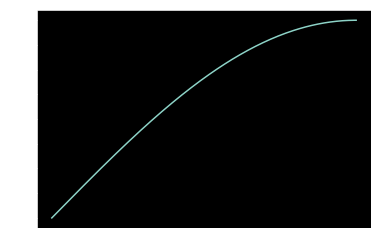

In [100]:
xx = np.linspace(0,np.pi,N)
yy=[]
for p in range(N):
        y = event[p](0,xx)*2
        yy += [y]
plt.plot(yy)

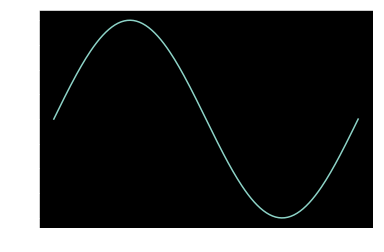

In [101]:
xx = np.linspace(0,np.pi*4,N)
yy=[]
for p in range(N):
        y = event[p](0,xx)*2
        yy += [y]
plt.plot(yy)

In [102]:
for func in event: 
        func.terminal = True

tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
                event[j].terminal = False
print(sol.message)
print(tNow)
# print(len(xNow))

102
A termination event occurred.
9.500914713373855e-05


In [103]:
p=np.argmin(np.mod(x_tilde,2*np.pi))
print(x_target[p])
print(x_tilde[p])

0.3089137920113165
0.007976000276099349


In [104]:
p=np.argmin(np.mod(x_0,2*np.pi))
print(x_0[p])
print(x_target[p])
print(x_tilde[p])

0.00033775312337480656
-1.896655757319409
-1.9789018372596745


[9.500914713373855e-05]
[-6.77626358e-20]
[9.50091471e-05]


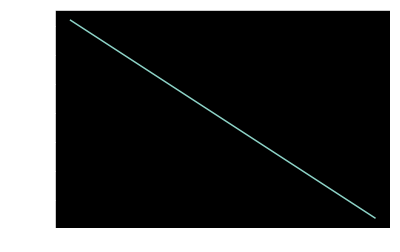

In [105]:
p=102
plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire]))
print(x[p,t==tFire])

In [106]:
p=102
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire]))
print(x[:5,t==tFire])

[9.500914713373855e-05]
[-6.77626358e-20]
[[ 0.56336514]
 [ 1.35992894]
 [-0.35826796]
 [ 0.42016635]
 [-0.75991889]]


In [107]:
p=102
plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire][0]))
print(x[:5,t==tFire][0])

[9.500914713373855e-05]


IndexError: index 102 is out of bounds for axis 0 with size 1

[9.500914713373855e-05]
9.500914713373842e-05


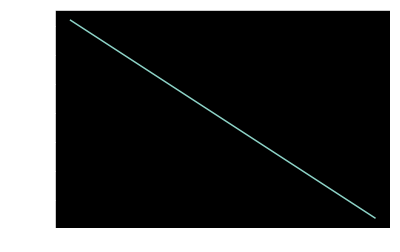

In [108]:
p=102
plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
# print(event[p](tFire,x[:,t==tFire][0]))
print(x[p,t==tFire][0])

In [109]:
p=102
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire][0]))
print(x[p,t==tFire][0])

[9.500914713373855e-05]


IndexError: index 102 is out of bounds for axis 0 with size 1

In [110]:
p=102
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire]))
print(x[p,t==tFire][0])

[9.500914713373855e-05]
[-6.77626358e-20]
9.500914713373842e-05


In [111]:
p=102
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire][:,0]))
print(x[p,t==tFire][0])

[9.500914713373855e-05]
-6.776263578034403e-20
9.500914713373842e-05


In [112]:
p=np.argmin(np.mod(x_0,2*np.pi))
print(x_0[p])
print(x_target[p])
print(x_tilde[p])

0.00033775312337480656
-1.896655757319409
-1.9789018372596745


In [113]:
p=np.argmin(np.mod(x_0,2*np.pi))
print(p)
print(x_0[p])
print(x_target[p])
print(x_tilde[p])

59
0.00033775312337480656
-1.896655757319409
-1.9789018372596745


In [114]:
p=59
# plt.plot(t,x[p,:])
te = list(sol.t_events[p])
print(te)
tFire = te[-1]
print(event[p](tFire,x[:,t==tFire][:,0]))
print(x[p,t==tFire][0])

[]


IndexError: list index out of range

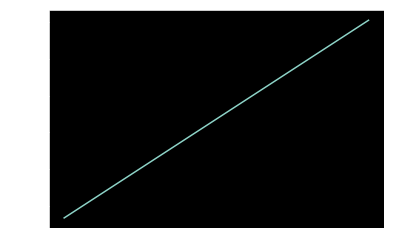

In [115]:
p=59
plt.plot(t,x[p,:])

In [116]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
A termination event occurred.
0.0015971117312915362
65


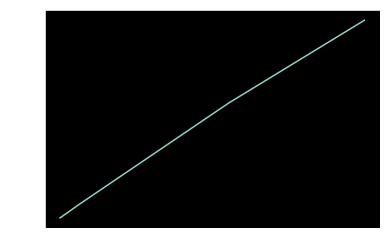

In [117]:
p=65
plt.plot(t,x[p,:])

In [118]:
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

102
A termination event occurred.
9.500914714305008e-05


In [119]:
sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
print(len(sol.t_events))
t = np.append(t,sol.t)
x = np.append(x,sol.y,axis=1)
tNow = t[-1]
xNow = x[:,-1]
print(sol.message)
print(tNow)
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)

200
A termination event occurred.
0.0015972064713912866
65


In [120]:
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

102
A termination event occurred.
9.500914714305008e-05


In [122]:
for func in event: 
        func.terminal = True # stop integration when any neuron fires
# first round
tf = 4*np.pi # end of simulation, unit in LFP phase
sol = solve_ivp(mainode,(0,tf),x_0,events=event) # integrate
                                # until a neuron fire
t = sol.t; tNow = t[-1]         # record time
x = sol.y; xNow = x[:,-1]       # state
for j,te in enumerate(sol.t_events):
        if te.size>0:
                print(j)
                x_fire[j] += list(te)      # update x_fire for calculating H
print(sol.message)
print(tNow)
# print(len(xNow))

102
A termination event occurred.
0.00010765393351171302


In [123]:
while tNow < tf:
        sol = solve_ivp(mainode,(tNow,tf),xNow,events=event)
        t = np.append(t,sol.t)          # integrate until one neuron
        x = np.append(x,sol.y,axis=1)   # fires, record time, state,
        tNow = t[-1]                    # firing time and neuron
        xNow = x[:,-1]                  # index
        for j,te in enumerate(sol.t_events): 
                event[j].terminal = True 
                if te.size>0:
                        x_fire[j] += list(te)  # update x_fire for calculating H
                        event[j].terminal = False
        print(sol.message)
        print(tNow)




A termination event occurred.
0.0015962515098685611
A termination event occurred.
0.0018677777951298148
A termination event occurred.
0.002685363156043531
A termination event occurred.
0.003206173439267229
A termination event occurred.
0.004211496565823273
A termination event occurred.
0.004455832187495316
A termination event occurred.
0.005685062812213559
A termination event occurred.
0.005983980924149852
A termination event occurred.
0.006808465519482958
A termination event occurred.
0.006949583242168529
A termination event occurred.
0.00790909603757428
A termination event occurred.
0.008360800900892293
A termination event occurred.
0.011518390595077787
A termination event occurred.
0.014521947654822932
A termination event occurred.
0.017250834756905815
A termination event occurred.
0.02699588484997697
A termination event occurred.
0.02980546969876851
A termination event occurred.
0.03323787202311135
A termination event occurred.
0.036444435732925155
A termination event occurred.
0.0

A termination event occurred.
1.8625295953583136
A termination event occurred.
1.866619123168084
A termination event occurred.
1.8682677166616781
A termination event occurred.
1.8712796156817775
A termination event occurred.
1.8712937564878496
A termination event occurred.
1.883689292102802
A termination event occurred.
1.8846893150831598
A termination event occurred.
1.8885184983255048
A termination event occurred.
1.893028128090568
A termination event occurred.
1.893836063836473
A termination event occurred.
1.936191455730874
A termination event occurred.
1.9447868633466547
A termination event occurred.
2.0434774302756895
A termination event occurred.
2.0544805214327266
A termination event occurred.
2.0824500524422462
A termination event occurred.
2.0847506634836654
A termination event occurred.
2.1092539331763795
A termination event occurred.
2.1584909872545026
A termination event occurred.
2.1594792084257453
A termination event occurred.
2.164463701554694
A termination event occurr

A termination event occurred.
6.510808956330065
A termination event occurred.
6.513938552492875
A termination event occurred.
6.513956553641467
A termination event occurred.
6.522250105678546
A termination event occurred.
6.52946316863891
A termination event occurred.
6.5556865727641105
A termination event occurred.
6.561152860997
A termination event occurred.
6.566145757514933
A termination event occurred.
6.579306631052849
A termination event occurred.
6.587444198103344
A termination event occurred.
6.5875401080816784
A termination event occurred.
6.602026457026271
A termination event occurred.
6.60538123931396
A termination event occurred.
6.608888629314365
A termination event occurred.
6.621635453743533
A termination event occurred.
6.624925363416706
A termination event occurred.
6.635616546454763
A termination event occurred.
6.64891571002215
A termination event occurred.
6.6639594265822515
A termination event occurred.
6.696806934536583
A termination event occurred.
6.71440850521

A termination event occurred.
12.515066464047383
A termination event occurred.
12.520411987271737
A termination event occurred.
12.529814582429026
A termination event occurred.
12.557121902836345
The solver successfully reached the end of the integration interval.
12.566370614359172


In [124]:
def raster(x_fire):
        N = len(x_fire)
        fig,ax = plt.subplots()
        for i in range(N):
                for te in x_fire[i]:
                        ax.vlines(te,i,i+1)
        ax.set_ylim(0,N)
        fig.show()
        return fig
raster(x_fire)




KeyboardInterrupt: 

C:\Users\golde\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


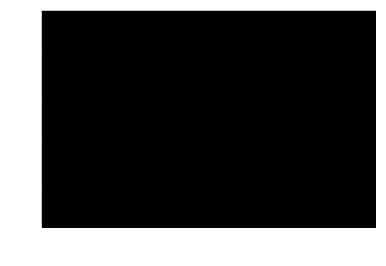

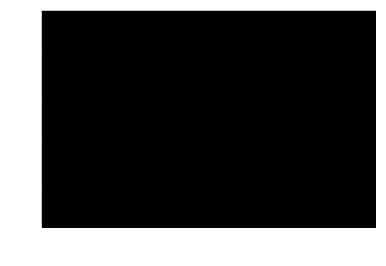

In [125]:
def raster(x_fire,inds):
        N = len(inds)
        fig,ax = plt.subplots()
        for i in inds:
                for te in x_fire[i]:
                        ax.vlines(te,i,i+1)
        ax.set_ylim(0,N)
        ax.set_xlabel('time in LFP phase')
        ax.set_ylabel('neuron')
        fig.show()
        return fig
raster(x_fire,range(10))




Text(0,0.5,'neuron')

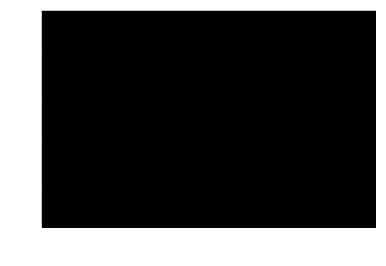

In [126]:
# def raster(x_fire,inds):
#         N = len(inds)
#         fig,ax = plt.subplots()
#         for i in inds:
#                 for te in x_fire[i]:
#                         ax.vlines(te,i,i+1)
#         ax.set_ylim(0,N)
#         ax.set_xlabel('time in LFP phase')
#         ax.set_ylabel('neuron')
#         fig.show()
#         return fig
# raster(x_fire,range(10))
inds = range(10)
N = len(inds)
for i in inds:
        for te in x_fire[i]:
                plt.vlines(te,i,i+1)
plt.ylim(0,N)
plt.xlabel('time in LFP phase')
plt.ylabel('neuron')

